# Defining and learning a causal model: Categorical Variables

###  import  modules

In [9]:
import os 
from pprint import pprint

import daft
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pgmpy.models

%matplotlib inline

### now we read the dataset, we use the IBM Employee Attition Dataset here

In [4]:
data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
data.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# plot the distributions for the variabes we are interested in

<AxesSubplot:>

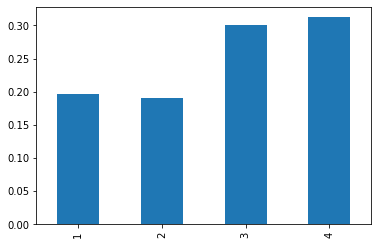

In [5]:
data.loc[:, "JobSatisfaction"].value_counts(normalize=True).sort_index().plot.bar()

<AxesSubplot:>

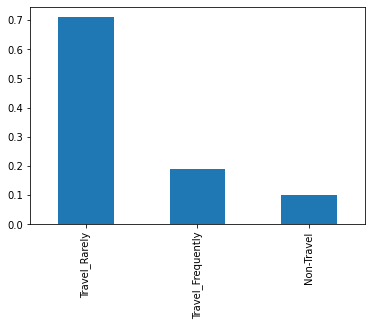

In [6]:
data.loc[:, "BusinessTravel"].value_counts(normalize=True).plot.bar()

<AxesSubplot:>

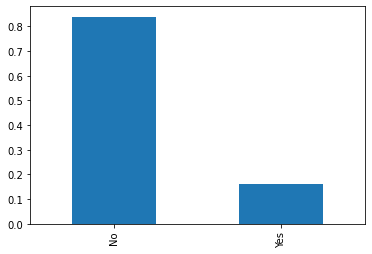

In [7]:
data.loc[:, "Attrition"].value_counts(normalize=True).plot.bar()

### build a small causal model, assuming JobSatisfaction is a cause of attrition, and BusinessTravel a cause for JobSatisfaction

### first, we plot the network

<Axes:>

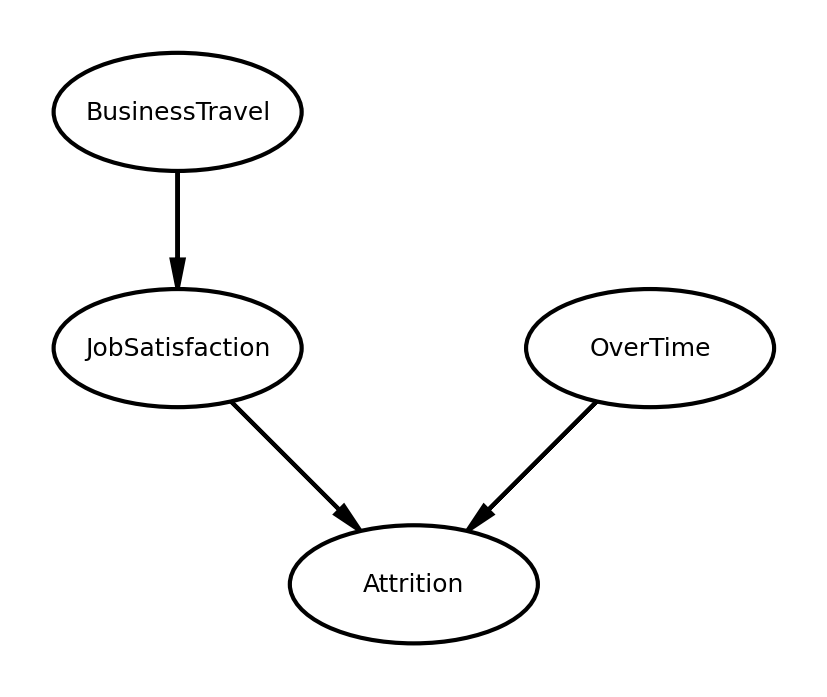

In [10]:
# ff = "comic sans ms"
ff = "impact"
#ff = "times new roman"
plt.rcParams["font.family"] = 'sans-serif'

plt.rcParams["font.size"] =6

pgm = daft.PGM(aspect=2.1, dpi=300)
pgm.add_node("OverTime", r"OverTime", 3, 1)# 3.0, 3.0)
pgm.add_node("Attrition", r"Attrition", 2, 0)# 3.0, 2.0, observed=True)
pgm.add_node("JobSatisfaction", r"JobSatisfaction", 1, 1)#, 5.0, 2.0, observed=True)
pgm.add_node("BusinessTravel", r"BusinessTravel",1 ,2)#5.0, 2.0, observed=True)
pgm.add_edge("BusinessTravel", "JobSatisfaction")
pgm.add_edge("JobSatisfaction", "Attrition")
pgm.add_edge("OverTime", "Attrition")
#pgm.add_edge("ugly", "bad")
#pgm.add_edge("confused", "bad")

pgm.render()

### Let's build a very small causal model, representing our assumpton that BusinessTravel is a cause for the job satisfaction

In [30]:
# edges is just a single edge
edges = [
    ("BusinessTravel", "JobSatisfaction"),
    ("JobSatisfaction", "Attrition"),
    ("OverTime", "Attrition"),
        ]

import pgmpy.models
model = pgmpy.models.BayesianModel(edges)
model.fit(data)

### before we continue further to the inference, let's have a close look at the CPT (conditional probability table) for the target nodes (job satisfaction)

In [17]:
ct = pd.crosstab(data.JobSatisfaction, data.BusinessTravel)
ct / ct.sum()

BusinessTravel,Non-Travel,Travel_Frequently,Travel_Rarely
JobSatisfaction,,,
1,0.153333,0.184116,0.206136
2,0.193333,0.176895,0.193672
3,0.360000,0.303249,0.291467
4,0.293333,0.335740,0.308725


In [18]:
ct = pd.crosstab(data.Attrition, [data.JobSatisfaction, data.OverTime])
ct / ct.sum()
#ct

JobSatisfaction        1                   2                   3            \
OverTime              No       Yes        No       Yes        No       Yes   
Attrition                                                                    
No               0.82439  0.642857  0.905213  0.623188  0.900312  0.661157   
Yes              0.17561  0.357143  0.094787  0.376812  0.099688  0.338843   

JobSatisfaction         4            
OverTime               No       Yes  
Attrition                            
No               0.930599  0.788732  
Yes              0.069401  0.211268

### inference: model the influence if we could completely reduce overtime

In [36]:
import pgmpy.inference
model.fit(data)
bp = pgmpy.inference.BeliefPropagation(model)
fact = bp.query(["Attrition"])
print("before intervention, the rate of attrition is", fact.values[1])
# vector multiplication with the scale to get the mean job satisfaction
#print(np.dot(fact.values, np.arange(1,5)))
cpt = model.get_cpds("OverTime")
print(cpt)
cpt.values[:] = [1, 0]
print(cpt)

#cpt = model.get_cpds("OverTime")

bp = pgmpy.inference.BeliefPropagation(model)
fact = bp.query(["Attrition"])
fact.values
print("after intervention, the rate of attrition is", fact.values[1])

#print(np.dot(fact.values, np.arange(1,5)))

Eliminating: JobSatisfaction: 100%|██████████| 2/2 [00:00<00:00, 445.82it/s]

before intervention, the rate of attrition is 0.16241109864797657
+---------------+----------+
| OverTime(No)  | 0.717007 |
+---------------+----------+
| OverTime(Yes) | 0.282993 |
+---------------+----------+
+---------------+---+
| OverTime(No)  | 1 |
+---------------+---+
| OverTime(Yes) | 0 |
+---------------+---+
after intervention, the rate of attrition is 0.10422360459744233


### therefore, we can almost reduce attrition by 6ppt. That wpuld mean ~50% less attrition